In [2]:
#data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from datetime import datetime

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='WCeprpzpVUPqPnSMNxuqmIxggEYopEc7BhoY-aKWKCEu',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu-de.cloud-object-storage.appdomain.cloud')

bucket = 'bigdataanalysis-donotdelete-pr-qjwjde4tacfpoa'
object_key = 'data2.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()
print(data.dtypes)

data.dropna(inplace=True)

# Convert the 'date_column' to datetime
data['date_column'] = pd.to_datetime(data['dt'], format='%Y-%M-%d')

# Exclude 'date_column' from imputation
features_to_impute = data.drop(['date_column', 'dt'], axis=1)

# Impute missing values in the features
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features_to_impute)
data[features_to_impute.columns] = features_imputed

# Continue with outlier detection and scaling as before
outlier_model = IsolationForest(contamination=0.05)
outliers = outlier_model.fit_predict(data.drop(['date_column', 'dt'], axis=1))
data = data[outliers != -1]

scaler = StandardScaler()
data[['LandAverageTemperature', 'LandAverageTemperatureUncertainty']] = scaler.fit_transform(data[['LandAverageTemperature', 'LandAverageTemperatureUncertainty']])

# Feature engineering and saving the preprocessed data
# ... (as in your original code)


# Feature engineering
data['new_feature'] = data['LandMaxTemperature'] * data['LandMinTemperature']  # Example interaction feature
data['feature_bin'] = pd.cut(data['LandAndOceanAverageTemperature'], bins=5, labels=['Low', 'Medium', 'High', 'Very High', 'Extreme'])  # Example binning

# Save the preprocessed data
data.to_csv("preprocessed_data.csv", index=False)
print("dataset are preprocessed sucessfully!")





dt                                            object
LandAverageTemperature                       float64
LandAverageTemperatureUncertainty            float64
LandMaxTemperature                           float64
LandMaxTemperatureUncertainty                float64
LandMinTemperature                           float64
LandMinTemperatureUncertainty                float64
LandAndOceanAverageTemperature               float64
LandAndOceanAverageTemperatureUncertainty    float64
dtype: object
dataset are preprocessed sucessfully!


/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [3]:
#apply advane tecniques
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='WCeprpzpVUPqPnSMNxuqmIxggEYopEc7BhoY-aKWKCEu',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu-de.cloud-object-storage.appdomain.cloud')

bucket = 'bigdataanalysis-donotdelete-pr-qjwjde4tacfpoa'
object_key = 'data2.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()
data.dropna(inplace=True)


data['date_column'] = pd.to_datetime(data['dt'], format='%Y-%m-%d')

data['LandAverageTemperatureUncertainty'] = data['LandAverageTemperatureUncertainty'].astype(float)
#print(data.dtypes)
target_variable= data['date_column']
data.index = pd.date_range(start=data.index[0], periods=len(data), freq='M')
result = seasonal_decompose(data['LandAverageTemperatureUncertainty'], model='additive')

target = data['LandAverageTemperatureUncertainty']
features = data.drop(['dt', 'date_column', 'LandAverageTemperatureUncertainty'], axis=1)  # Adjust columns as needed

#data['LandAverageTemperature'] = data['LandAverageTemperature'].astype(float)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, random_state=42)  # Adjust min_samples

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.0015826461942355877
R-squared: 0.9637454799075565


In [4]:
#model training
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='WCeprpzpVUPqPnSMNxuqmIxggEYopEc7BhoY-aKWKCEu',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu-de.cloud-object-storage.appdomain.cloud')

bucket = 'bigdataanalysis-donotdelete-pr-qjwjde4tacfpoa'
object_key = 'data2.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()
data.dropna(inplace=True)


data['date_column'] = pd.to_datetime(data['dt'], format='%Y-%m-%d')

# Define your target variable and features
target = data['LandAverageTemperatureUncertainty']
features = data.drop(['dt', 'date_column', 'LandAverageTemperatureUncertainty'], axis=1)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the model (Random Forest Regressor, for example)
model = RandomForestRegressor()

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Adjust as needed
    'max_depth': [None, 10, 20],    # Adjust as needed
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the model with the best hyperparameters
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model (e.g., for regression)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")




Best Hyperparameters: {'max_depth': None, 'n_estimators': 200}
Mean Squared Error: 0.0015485599856516277
R-squared: 0.9645263108592143


In [5]:
#code Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from datetime import datetime
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='WCeprpzpVUPqPnSMNxuqmIxggEYopEc7BhoY-aKWKCEu',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu-de.cloud-object-storage.appdomain.cloud')

bucket = 'bigdataanalysis-donotdelete-pr-qjwjde4tacfpoa'
object_key = 'data2.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()
data.dropna(inplace=True)


data['date_column'] = pd.to_datetime(data['dt'], format='%Y-%m-%d')
data['LandAverageTemperature'] = data['LandAverageTemperature'].astype(float)


# Define your target variable and features
target = data['LandAverageTemperature']
features = data.drop(['dt', 'date_column', 'LandAverageTemperature'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the model (Random Forest Regressor, for example)
model = RandomForestRegressor(n_estimators=100, max_depth=None)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance (e.g., for regression)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Cross-validation for model robustness
scoring = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(model, features, target, cv=5, scoring=scoring)

# Calculate the mean RMSE from cross-validation
mean_cv_rmse = (-cv_scores).mean()**0.5

print(f"Mean Cross-Validated RMSE: {mean_cv_rmse}")


Root Mean Squared Error (RMSE): 0.1900384326602647
Mean Cross-Validated RMSE: 0.348565093780341


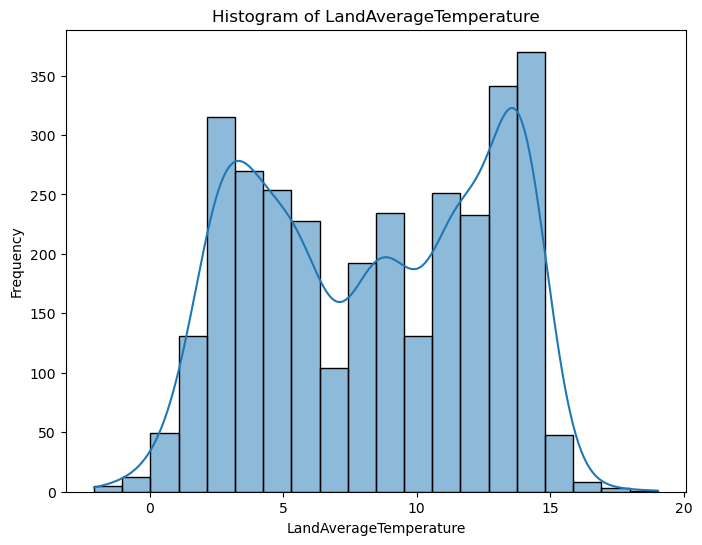

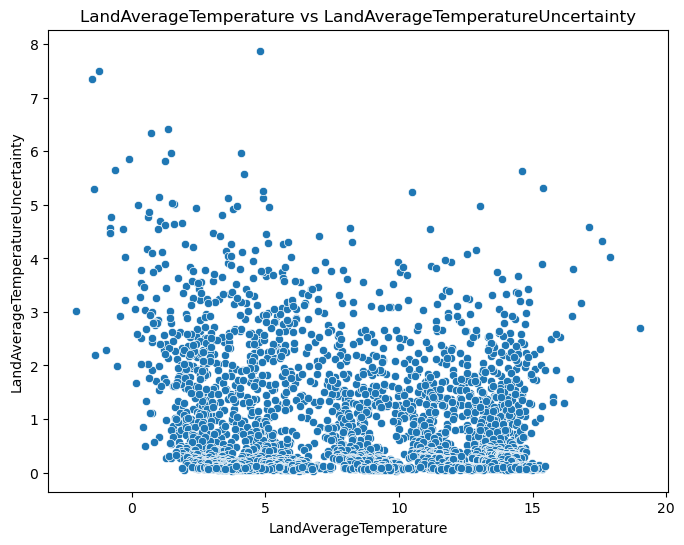

/tmp/wsuser/ipykernel_270/1431732839.py:61: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


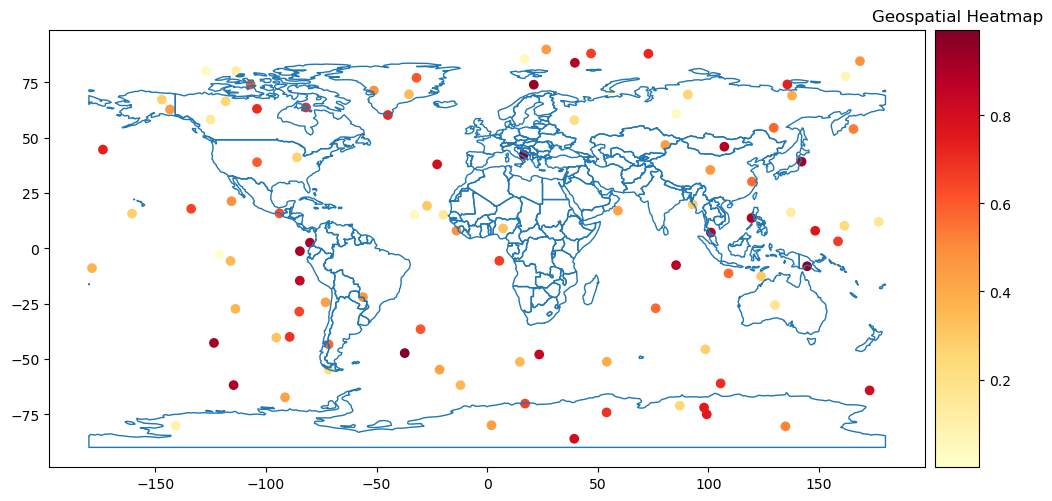

In [2]:
#visulation
import matplotlib.pyplot as plt
import seaborn as sns
import os, types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='WCeprpzpVUPqPnSMNxuqmIxggEYopEc7BhoY-aKWKCEu',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu-de.cloud-object-storage.appdomain.cloud')

bucket = 'bigdataanalysis-donotdelete-pr-qjwjde4tacfpoa'
object_key = 'data2.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()
# Example 1: Histogram
plt.figure(figsize=(8, 6))
sns.histplot(data['LandAverageTemperature'], kde=True, bins=20)
plt.xlabel('LandAverageTemperature')
plt.ylabel('Frequency')
plt.title('Histogram of LandAverageTemperature')
plt.show()


# Example 2: Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='LandAverageTemperature', y='LandAverageTemperatureUncertainty', data=data)
plt.xlabel('LandAverageTemperature')
plt.ylabel('LandAverageTemperatureUncertainty')
plt.title('LandAverageTemperature vs LandAverageTemperatureUncertainty')
plt.show()

# Example 3: Geospatial Heatmap (requires geospatial data)
# You can use libraries like Geopandas for working with geospatial data
# Here's a simplified example using random data
import geopandas as gpd
import geopandas.tools
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Generate random geospatial data
n = 100
gdf = gpd.GeoDataFrame(
    {'value': np.random.rand(n)},
    geometry=gpd.points_from_xy(np.random.rand(n) * 360 - 180, np.random.rand(n) * 180 - 90),
)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a geospatial heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.boundary.plot(ax=ax, linewidth=1)
gdf.plot(column='value', cmap='YlOrRd', ax=ax, cax=cax, legend=True)
plt.title('Geospatial Heatmap')
plt.show()




In [8]:
pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 49.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 51.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
